In [2]:
# Import the libraries for the data quality step
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interactive
from ipywidgets import Layout, FileUpload
from IPython.display import Markdown, display
import scipy.io as spio
import numpy as np
import math
import io
import os
import random
import datetime
import pyreadstat
import seaborn as sns
from IPython.display import clear_output
from pathlib import Path
import plotly.graph_objects as go
from ipywidgets import VBox, HBox, Label, Box
from ipywidgets import interact, Dropdown

def printmd(string):
    display(Markdown(string))

# Data collection

### Direct upload

In [3]:
# ----- For testing purposes ------
file_path = "./Datasets/dementiadatacollectionoctober2014csv15kb.csv"
data = pd.read_csv(file_path)

### Use the upload button

In [328]:
# Shows the upload widget
upload = FileUpload(accept='')
upload

FileUpload(value={}, description='Upload')

In [329]:
try:
    upload.value
    uploaded_filename = next(iter(upload.value))
    new_filename = uploaded_filename[:-3] + 'csv'
    content = upload.value[uploaded_filename]['content']
    file_path = os.path.abspath(uploaded_filename)
    filename, file_extension = os.path.splitext(file_path)
    data = pd.read_csv(io.BytesIO(content), header=0, escapechar='\\', encoding= 'unicode_escape')
except StopIteration:
    printmd("#### Please enter a valid file.**")

### Dataset preview 

In [251]:
data.head()

,pidno,idno,city,group,batch,becktnt1,becktlt1,becksct1,beckyrt1,becktnt2,...,yesvyrt2,yesvtnt3,yesvtlt3,yesvgst3,yesvyrt3,yesvtnt4,yesvtlt4,yesvgst4,yesvyrt4,VAR00001
0,10001,-9,1,1,1.0,NaN,NaN,6,1985,13,...,1995,11,10001.11,3,1999,15,10001.15,,2003,10001
1,10002,2,1,1,1.0,1.0,10001.01,0,1985,13,...,1995,11,10001.11,0,1999,15,10001.15,1,2003,10002
2,10003,3,1,1,1.0,1.0,10001.01,18,1985,13,...,1995,11,10001.11,19,1999,15,10001.15,,2003,10003
3,10004,4,1,1,1.0,1.0,10001.01,12,1985,13,...,1995,11,10001.11,18,1999,15,10001.15,,2003,10004
4,10005,5,1,1,1.0,1.0,10001.01,9,1985,13,...,1995,11,10001.11,12,1999,15,10001.15,8,2003,10005


# General dataset metadata

In [71]:
print("\u0332".join("Descriptive metadata\n"))
    
filename, file_extension = os.path.splitext(file_path)
file_extension = file_extension.replace(".", "")
file_path_obj = Path(file_path)

print("Format: {}".format(file_extension))
print("Size: {} elements".format(data.size))


print("\u0332".join("Structural metadata\n"))
print("All column names: {}\n".format(list(data.columns)))
# data.isna().sum() is needed because the count function only returns the total number of non-na elements
print("Total number of values for each column: \n\n{} ".format(data.count() + data.isna().sum()))



D̲e̲s̲c̲r̲i̲p̲t̲i̲v̲e̲ ̲m̲e̲t̲a̲d̲a̲t̲a̲

Format: csv
Size: 2957072 elements
S̲t̲r̲u̲c̲t̲u̲r̲a̲l̲ ̲m̲e̲t̲a̲d̲a̲t̲a̲

All column names: ['panelid', 'idno', 'city', 'grp', 'batch', 'dobdate', 'dobyear', 'pob', 'sex', 'soclass', 'occupcd', 'educlev', 'ISCED97total', 'ISCED97USyears', 'brfoccup', 't1tb1age', 'p1issue', 'test1dat', 'p1issdat', 'p1comp', 'p1age', 'p1father', 'p1agef', 'p1cdthf', 'p1mother', 'p1agem', 'p1cdthm', 'p1broths', 'p1broth1', 'p1agebr1', 'p1cdthb1', 'p1broth2', 'p1agebr2', 'p1cdthb2', 'p1broth3', 'p1agebr3', 'p1cdthb3', 'p1broth4', 'p1agebr4', 'p1cdthb4', 'p1broth5', 'p1agebr5', 'p1cdthb5', 'p1broth6', 'p1agebr6', 'p1cdthb6', 'p1broth7', 'p1agebr7', 'p1cdthb7', 'p1broth8', 'p1agebr8', 'p1cdthb8', 'p1sister', 'p1sist1', 'p1agest1', 'p1cdths1', 'p1sist2', 'p1agest2', 'p1cdths2', 'p1sist3', 'p1agest3', 'p1cdths3', 'p1sist4', 'p1agest4', 'p1cdths4', 'p1sist5', 'p1agest5', 'p1cdths5', 'p1sist6', 'p1agest6', 'p1cdths6', 'p1sist7', 'p1agest7', 'p1cdths7', 'p1sist8', 'p1age

# Values distribution for a specific column

In [102]:
# Unique values for each column
# data = data[1:]

df_features = pd.DataFrame(index = data.columns)
# df[rowMeans(df!=0)>0.25, ] 
df_features['Total_Values'] = list(map(lambda x: data[x].count(), data.columns))
df_features['Unique_Values'] = list(map(lambda x: data[x].value_counts().count(), data.columns))

df_features['Most_Frequent_Value'] = list(map(lambda x: data[x].value_counts().sort_values(ascending = False), data.columns))
df_features['Most_Frequent_Value_Count'] = list(map(lambda x: data[x].value_counts().sort_values(ascending = False), data.columns))
df_features['Type_Data'] = list(map(lambda x: data[x].dtype, data.columns))

def compute_values_dist_column(column_name):
    plt.figure(figsize=(20,5))
    if df_features['Unique_Values'][column_name] > 100:
         fig = px.histogram(data, y=column_name,
                            color_discrete_sequence =['#d595e8'],
                            barmode="group",
                            title="Values distribution for column '{}'".format(column_name)).update_yaxes(categoryorder="total ascending")
    else:
         fig = px.histogram(data, y=column_name,
                            color_discrete_sequence =['#d595e8'],
                            barmode="group", 
                            title="Values distribution for column '{}'".format(column_name)).update_yaxes(categoryorder="total ascending")
    fig.show()

w = widgets.Dropdown(options = data.columns, description="Column: ", value = None)
def on_change(change):
    with outs:
        clear_output(wait=True)
        if change['type'] == 'change' and change['name'] == 'value':
            print(" ----- Values distribution histogram for %s -----" % change['new'])
            compute_values_dist_column(change['new'])

outs = widgets.Output()
w.observe(on_change, names='value')
display(w)
display(outs)

# Clean up
with outs:
    clear_output()


Dropdown(description='Column: ', options=('panelid', 'idno', 'city', 'grp', 'batch', 'dobdate', 'dobyear', 'po…

Output()

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

#  Unique values for a specific column

In [61]:
def get_unique_values_count(req_data, req_column):
    return [req_data[req_column].value_counts().index.tolist(), req_data[req_column].value_counts()]


def unique_values_dist_column(unique_values, column_name):
    try:
        plt.figure(figsize=(40, 15))
    
        fig = go.Figure(data=[go.Table(
                header = dict(values=[column_name, "Number of appearances"],
                         fill_color='paleturquoise', align='center'),
                cells = dict(values = [unique_values[0], unique_values[1]],
                             font = dict(family="Times New Roman", size=14,)))])
        fig.update_layout(title_text="Unique values for column %s" % column_name,
                          title_font_size=24, title_x=0.5, autosize=True)
        fig.show()
    except KeyError:
        printmd("## Please select a column.")
    except IndexError:
        printmd("## Please select a column.")
        
def on_change(change):
    with outs:
        clear_output(wait=True)
        if change['type'] == 'change' and change['name'] == 'value':
            unique_values = get_unique_values_count(data, change['new'])
            unique_values_dist_column(unique_values, change['new'])

outs = widgets.Output()
w = widgets.Dropdown(options = data.columns, description="Column: ", value = None)
w.observe(on_change, names='value')
display(w)
display(outs)

# Clean up
with outs:
    clear_output()

Dropdown(description='Column: ', options=('pidno', 'idno', 'city', 'group', 'batch', 'becktnt1', 'becktlt1', '…

Output()

<Figure size 2880x1080 with 0 Axes>

<Figure size 2880x1080 with 0 Axes>

<Figure size 2880x1080 with 0 Axes>

# Assessing the plausibility of the dataset

## Column similarity

In [ ]:
f, ax = plt.subplots(figsize=(20, 11))
try:
    printmd("### Heatmap for column similarity: ")
    df = data.apply(lambda x: x.factorize()[0]).corr()
    sns.heatmap(df, annot=True, annot_kws={"size": 10}, linewidths=.5, cmap="BuPu")
except ValueError:
    pass

### Similarity between missing values indexes

In [209]:
def get_cosine_similarity(req_arr1, req_arr2):
    req_arr1 = req_arr1[0]
    req_arr2 = req_arr2[0]
    if len(req_arr2) > len(req_arr1):
        req_arr1 = list(map(lambda x: 0 if x not in req_arr1 else x, req_arr2))
    elif len(req_arr1) > len(req_arr2):
        req_arr2 = list(map(lambda x: 0 if x not in req_arr2 else x, req_arr1))
    dot_product = sum(x * y for (x, y) in zip(req_arr1, req_arr2))
    magnitude_arr1 = math.sqrt(sum(pow(x, 2) for x in req_arr1))
    magnitude_arr2 = math.sqrt(sum(pow(x, 2) for x in req_arr2))
    if magnitude_arr1 == 0 or magnitude_arr2 == 0:
        return 0.0
    else:
        return (dot_product / (magnitude_arr1 * magnitude_arr2))
    
def has_null_value(data, null_list):
    null_elem = []
    for c in data.columns:
        for elem in data[c]:
            if elem in null_list:
                null_elem.append(elem)
    return null_elem

values = pd.Series()
for column in data.columns:
    values[column] = np.where(data[column].isnull() | data[column].isin(['NIL RETURN']))

missing_val_indexes = values.drop(values.index[[index for index, value in enumerate(values) if value[0].size == 0]])
print(missing_val_indexes)

df = pd.DataFrame(columns = missing_val_indexes.index, index =  missing_val_indexes.index)

for current_index_row in range(len(missing_val_indexes)):
    for current_index_column in range(len(missing_val_indexes)):
        df.iloc[current_index_row][current_index_column] = float(get_cosine_similarity(missing_val_indexes[current_index_row], missing_val_indexes[current_index_column]))
        
for column in df.columns:
    df[column] = df[column].astype('float')

printmd("## Similarity matrix for missing values indexes: ")    
display(df)


becktnt1    ([0],)
becktlt1    ([0],)
test        ([2],)
dtype: object


<ipython-input-209-8eaaac84cb03>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  values = pd.Series()


## Similarity matrix for missing values indexes: 

,becktnt1,becktlt1,test
becktnt1,0.0,0.0,0.0
becktlt1,0.0,0.0,0.0
test,0.0,0.0,1.0


### Similarity heatmap for missing values indexes

## Heatmap for missing values similarity: 

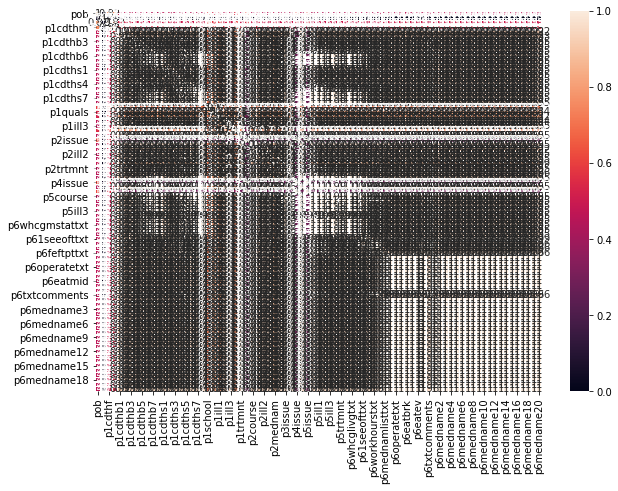

In [114]:
f, ax = plt.subplots(figsize=(10, 7))
try:
    printmd("## Heatmap for missing values similarity: ")
    sns.heatmap(df, annot=True, annot_kws={"size": 10}, linewidths=.5, cmap="BuPu")
except ValueError:
    pass

# Missing values analysis

Check for any missing value

In [290]:
customised_missing_values = []

def on_submit_button_click(b):
    # Avoids adding empty strings to the list
    if len(values.value) > 0:
        result = [x.strip() for x in values.value.split(',')]
        customised_missing_values.extend(result)
        print("Customised missing values list: {}".format(customised_missing_values))

    
printmd("### Customised missing value")
printmd("Any entry that is equal to this customised missing value will be marked as 'missing'. If you have made a mistake, please rerun the cell.")
printmd("You can mention more values by separating them by commas - e.g -9, 10, NULL")

values = widgets.Text(description='Value')
button = widgets.Button(description="Submit")
Box = widgets.HBox([values, button])

button.on_click(on_submit_button_click)
Box

### Customised missing value

Any entry that is equal to this customised missing value will be marked as 'missing'. If you have made a mistake, please rerun the cell.

You can mention more values by separating them by commas - e.g -9, 10, NULL

Customised missing values list: ['-9']


In [291]:
def check_missing_values(dfObj):
    resultDict = {}
    count = 0
    for elem in dfObj:
        if elem in customised_missing_values or len(str(elem).strip()) == 0:
            resultDict[count] = True
        else:
            resultDict[count] = False
        count +=1
    return pd.Series(resultDict)

missing_values = pd.DataFrame()
missing_data = data.apply(lambda x: sum(check_missing_values(x)), axis=0).sort_values(ascending=False)
missing_values['missing_values_count'] = missing_data.values
missing_values['feature_name'] = missing_data.index
missing_values = missing_values[missing_values['missing_values_count'] != 0]


if missing_values.empty == True and df.isna().values.any() == False:
    print("There are no missing values in the data.")
else:
    printmd("### The missing values:")
    print(missing_values)

### The missing values:

    missing_values_count feature_name
0                   5825     yesvgst4
1                   5107     yesvgst3
2                   4180     yesvgst2
3                   4071         test
4                   4010     yesvtlt4
5                   4010     yesvtnt4
6                   4010     yesvyrt4
7                   3100     yesvgst1
8                   1332     beckyrt2
9                   1332     becktnt2
10                  1332     becktlt2
11                  1322     yesvtlt3
12                  1322     yesvyrt3
13                  1322     yesvtnt3
14                   892     becksct1
15                   687     yesvtlt2
16                   687     yesvtnt2


# Cleaning the dataset

In [389]:
def get_10_related_columns(column_name, data):
    df = data.apply(lambda x: x.factorize()[0]).corr()
    df = df.sort_values(by=column_name, ascending=False, axis=1)    
    top_10_related_columns = []
        
    for row in df:
        if row == column_name:
            for i in range(len(df)):
                top_10_related_columns.append(df.columns[i])
                if i + 1== len(data.columns) or len(top_10_related_columns) == 10:
                    return top_10_related_columns
                
# This drops empty strings, NA values and any values that the user 
# added to the customisation of missing values step
def remove_column(column_name):
    print("Initial shape of data set: ", data.shape)
    data.drop([column_name], axis=1, inplace=True)
    print("After removal shape of data set:", data.shape)
    columnDrop.options = data.columns
    print("Column removed!")
   
        
# This function is performed in place 
# (directly changing the value of the variable data)
def modify_values(column_name, replace_value):
    try:
        data[[column_name]] = data[[column_name]].fillna(value=replace_value)
        data[[column_name]] = data[[column_name]].replace(' ', replace_value)
        data[[column_name]] = data[[column_name]].replace('', replace_value)

        for mv in customised_missing_values:
            data[[column_name]] = data[[column_name]].replace(int(float(mv)), replace_value)
        print("The missing values have been replaced with {}".format(replace_value))
    except TypeError:
        print(">> Error found when selecting transformation.")
def on_button_clicked(b):
    with output:
        try:
            column_name = columnDrop.value
            if transformationDrop.value == "Remove column":
                remove_column(column_name)
                columnDrop.options = data.columns
            elif transformationDrop.value == "Change values to 0":
                modify_values(column_name, 0)
            elif transformationDrop.value == "Change values to NULL":
                modify_values(column_name, 'NULL')
            elif transformationDrop.value == "Change values to avg":
                modify_values(column_name, data[column_name].mean())
        except TypeError as e:
            print(">> This action is not supported on the mentioned column!", e)

layout = Layout(display='flex')

printmd("## Missing values dataset transformation")
columnDrop = Dropdown(description="Column", options = data.columns, layout=layout, style = {'description_width': 'initial'}, value = None)
transformationDrop = Dropdown(description="Transformations", options =  ["Remove column", "Change values to 0", "Change values to NULL", "Change values to avg"], layout=layout, style = {'description_width': 'initial'}, value = None)
applyDrop = Dropdown(description="Apply to", layout=layout, style = {'description_width': 'initial'}, value = None)
relatedColumnsDrop = Dropdown(description="Related columns", layout=layout, style = {'description_width': 'initial'}, value = None)
saveToDrop = Dropdown(description="Save to", options= ["Your computer", "AWS"], layout=layout, style = {'description_width': 'initial'}, value = None)

button = widgets.Button(description="Submit")
output = widgets.Output()
button.on_click(on_button_clicked)


def update_columnDrop_options(*args):
    applyDrop.options = [columnDrop.value, "Related columns"]
columnDrop.observe(update_columnDrop_options) 

def update_applyDrop_options(*args):
    if applyDrop.value == "Related columns":
        relatedColumnsDrop.options = get_10_related_columns(columnDrop.value, data)
    else:
        relatedColumnsDrop.options = ''
applyDrop.observe(update_applyDrop_options) 



@interact(column = columnDrop, transformations=transformationDrop, apply = applyDrop, save_to = saveToDrop, related_col = relatedColumnsDrop)
def print_arguments(column, transformations, apply, save_to, related_col):
    if column is not None and transformations is not None and apply is not None and save_to is not None:
        if apply == "Related columns":
            if len(related_col) > 0 :
                display(button, output)
        else: 
            display(button, output)


## Missing values dataset transformation

interactive(children=(Dropdown(description='Column', layout=Layout(display='flex'), options=('pidno', 'idno', …

In [378]:
data[['becktnt2']] = data[['becktnt2']].replace('NULL', np.nan)

In [384]:
data.head()

,pidno,idno,city,group,batch,becktnt1,becktlt1,becksct1,beckyrt1,becktnt2,...,yesvyrt2,yesvtnt3,yesvtlt3,yesvgst3,yesvyrt3,yesvtnt4,yesvtlt4,yesvgst4,yesvyrt4,VAR00001
0,10001,1,1.0,1,1.0,0.0,0.00,None,None,NULL,...,1995,11,10001.11,3,1999,15,10001.15,,2003,10001
1,10002,2,1.0,1,1.0,1.0,10001.01,None,None,NULL,...,1995,11,10001.11,0,1999,15,10001.15,1,2003,10002
2,10003,3,1.0,1,1.0,1.0,10001.01,None,None,NULL,...,1995,11,10001.11,19,1999,15,10001.15,,2003,10003
3,10004,4,1.0,1,1.0,1.0,10001.01,None,None,NULL,...,1995,11,10001.11,18,1999,15,10001.15,,2003,10004
4,10005,-9,NaN,1,1.0,1.0,10001.01,None,None,NULL,...,1995,11,10001.11,12,1999,15,10001.15,8,2003,10005
